#MLP Training on MNIST



In [ ]:
# # It should give some configurational to MLP network. It is gonna return the weights and biases of the network.
# def init_MLP()(layer widths):      # layer widths = configuration

#   params = []   # some list
#   # we are gonna iterate through the layer widths
#   #in_width = number of neurons coming into the layer, out_width = number of neurons going from the layer
#   for in_width, out_width


In [ ]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

# Importing MNIST dataset
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

Initialization Function

In [ ]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


Prediction Function

In [ ]:
def MLP_predict(params, x):
    # x = single flatten image as input                 
    hidden_layers = params[:-1]

    activation = x
    # Iterating through first two layers and taking the weight and bias matrices
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    # Getting last layers weight and biases so that the last layer does not have the relu activation    
    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


Add data loading in Pytorch

In [ ]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(128, 784) float32 (128,) int64


Training Loop Function and Optimizing

In [ ]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


0.24021588
0.09423733
0.055684555
0.03447799
0.036766905
0.04872058
0.03451236
0.026592076
0.03606854
0.02749948
Epoch 0, train acc = 0.9163333177566528 test acc = 0.9210000038146973
0.043314245
0.033192378
0.03219713
0.034661677
0.030951366
0.024236044
0.018526219
0.022023782
0.026549136
0.020686781
Epoch 1, train acc = 0.9348000288009644 test acc = 0.9361000061035156
0.024646506
0.020036655
0.02845726
0.03148792
0.029024264
0.024181822
0.020607367
0.017874848
0.011200915
0.016594881
Epoch 2, train acc = 0.9445833563804626 test acc = 0.9422999620437622
0.020323863
0.026097108
0.016507655
0.02366642
0.030215073
0.01813643
0.021626651
0.017321533
0.016359568
0.023814812
Epoch 3, train acc = 0.9531999826431274 test acc = 0.9488999843597412
0.01107387
0.011569125
0.008731325
0.021863727
0.011636501
0.015430144
0.020057531
0.015407409
0.01984917
0.019714044
Epoch 4, train acc = 0.9603166580200195 test acc = 0.9554999470710754


Visualizing the image and predicting

#Visualizations

(28, 28)
pred 7
gt 7


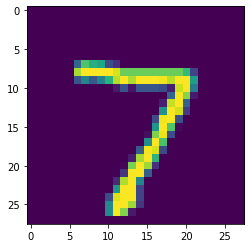

In [ ]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

Viualize the MLP weight

(512, 784)
(28, 28)


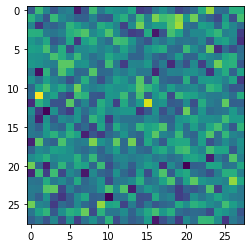

In [ ]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()

Resources


*   https://www.youtube.com/watch?v=CQQaifxuFcs&list=PLBoQnSflObckOARbMK9Lt98Id0AKcZurq&index=2
*   https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb


